In [61]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# Set data folder path
DATA_PATH = "../data/"

In [4]:
# Load metadata
products = pd.read_csv(os.path.join(DATA_PATH, "products.csv"))
aisles = pd.read_csv(os.path.join(DATA_PATH, "aisles.csv"))
departments = pd.read_csv(os.path.join(DATA_PATH, "departments.csv"))


In [5]:
# Load order-level data
orders = pd.read_csv(os.path.join(DATA_PATH, "orders.csv"))
order_products_prior = pd.read_csv(os.path.join(DATA_PATH, "order_products__prior.csv"))
order_products_train = pd.read_csv(os.path.join(DATA_PATH, "order_products__train.csv"))

### 🔍 Preview data

In [6]:
print("Products:")
display(products.head())

Products:


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
print("\nOrders:")
display(orders.head())


Orders:


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [8]:
print("\nPrior Order-Product Interactions:")
display(order_products_prior.head())


Prior Order-Product Interactions:


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### 📊 Exploratory Data Analysis (EDA)

In [9]:
# Merge order-product-prior with orders
order_prior_merged = order_products_prior.merge(orders, on='order_id', how='left')

In [10]:
# Reorder ratio overall
reorder_ratio = order_prior_merged['reordered'].mean()
print(f"Overall reorder ratio: {reorder_ratio:.2f}")

Overall reorder ratio: 0.59


In [11]:
# Most frequently ordered products
top_products = order_prior_merged['product_id'].value_counts().head(10).reset_index()
top_products.columns = ['product_id', 'order_count']
top_products = top_products.merge(products, on='product_id', how='left')
display(top_products)

,product_id,order_count,product_name,aisle_id,department_id
0,24852,472565,Banana,24,4
1,13176,379450,Bag of Organic Bananas,24,4
2,21137,264683,Organic Strawberries,24,4
3,21903,241921,Organic Baby Spinach,123,4
4,47209,213584,Organic Hass Avocado,24,4
5,47766,176815,Organic Avocado,24,4
6,47626,152657,Large Lemon,24,4
7,16797,142951,Strawberries,24,4
8,26209,140627,Limes,24,4
9,27845,137905,Organic Whole Milk,84,16


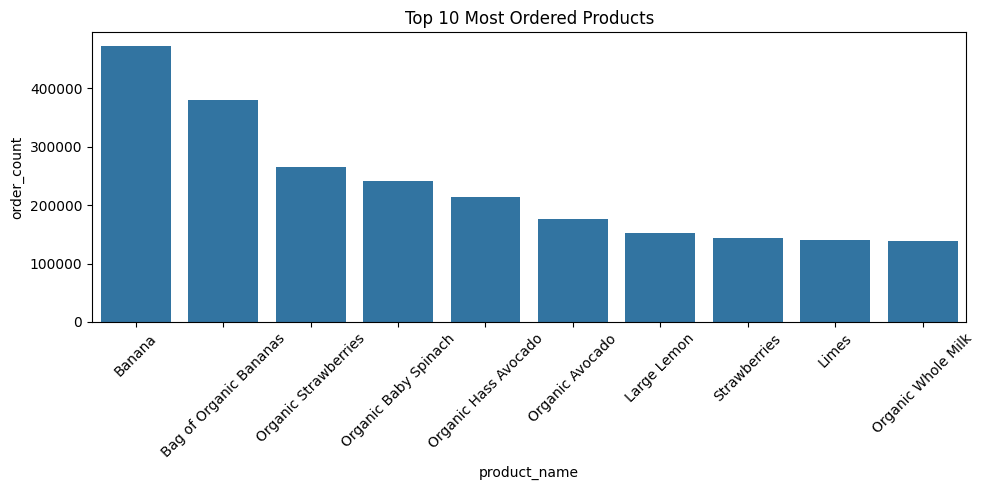

In [12]:
# Plot top products
plt.figure(figsize=(10, 5))
sns.barplot(x='product_name', y='order_count', data=top_products)
plt.title("Top 10 Most Ordered Products")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
# Products with highest reorder probability
reorder_prob = order_prior_merged.groupby('product_id')['reordered'].mean().sort_values(ascending=False)
top_reordered = reorder_prob.head(10).reset_index().merge(products, on='product_id')
display(top_reordered)

,product_id,reordered,product_name,aisle_id,department_id
0,6433,0.941176,Raw Veggie Wrappers,13,20
1,2075,0.931034,Serenity Ultimate Extrema Overnight Pads,126,11
2,43553,0.923077,Orange Energy Shots,64,7
3,27740,0.920792,Chocolate Love Bar,45,19
4,14609,0.914286,Soy Powder Infant Formula,92,18
5,13875,0.911111,Simply Sleep Nighttime Sleep Aid,6,2
6,39992,0.909091,"Energy Shot, Grape Flavor",64,7
7,31418,0.900000,Sparking Water,115,7
8,5868,0.900000,Russian River Valley Reserve Pinot Noir,28,5
9,35604,0.900000,Maca Buttercups,45,19


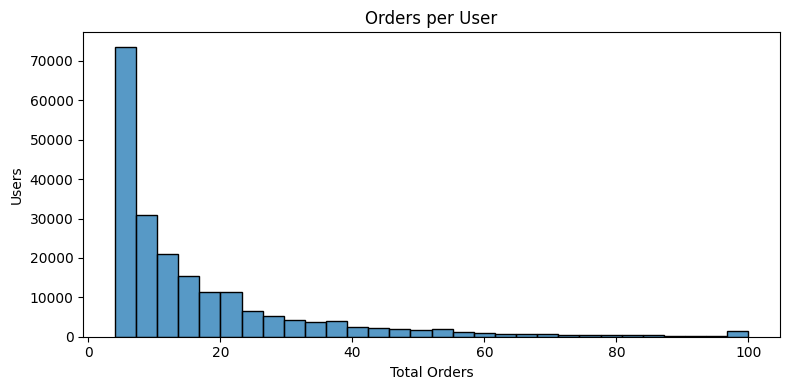

In [14]:
# Orders per user
orders_per_user = orders.groupby('user_id')['order_number'].max()
plt.figure(figsize=(8, 4))
sns.histplot(orders_per_user, bins=30, kde=False)
plt.title("Orders per User")
plt.xlabel("Total Orders")
plt.ylabel("Users")
plt.tight_layout()
plt.show()

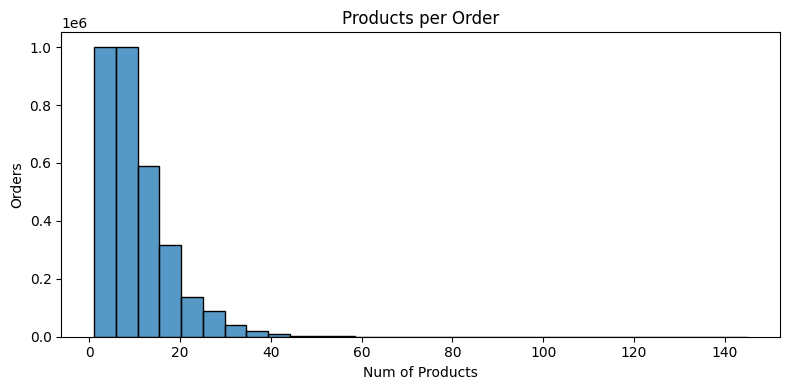

In [15]:
# Products per order
products_per_order = order_products_prior.groupby('order_id')['product_id'].count()
plt.figure(figsize=(8, 4))
sns.histplot(products_per_order, bins=30, kde=False)
plt.title("Products per Order")
plt.xlabel("Num of Products")
plt.ylabel("Orders")
plt.tight_layout()
plt.show()

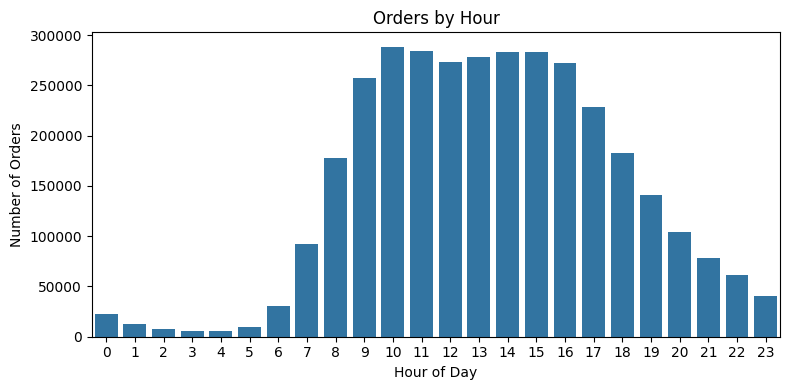

In [16]:
# Ordering by hour
plt.figure(figsize=(8, 4))
sns.countplot(x='order_hour_of_day', data=orders)
plt.title("Orders by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.tight_layout()
plt.show()


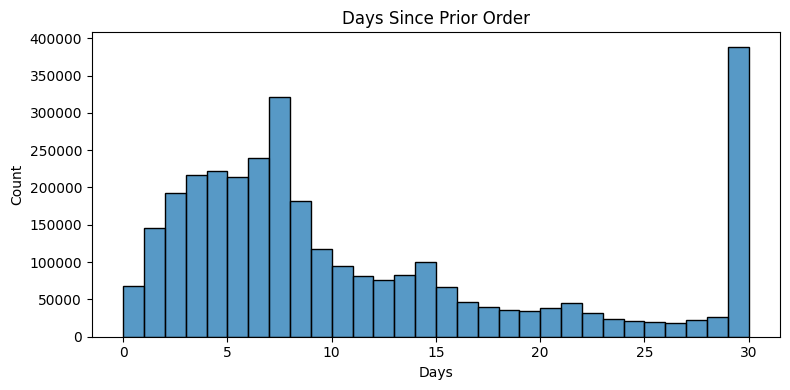

In [17]:
# Days since prior order
plt.figure(figsize=(8, 4))
sns.histplot(orders['days_since_prior_order'].dropna(), bins=30)
plt.title("Days Since Prior Order")
plt.xlabel("Days")
plt.tight_layout()
plt.show()

### 🧠 Feature Engineering (User-Product-Level)

user & product stats:

In [18]:
# User-level features
user_features = orders[orders['eval_set'] == 'prior'].groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': ['mean', 'std']
}).reset_index()
user_features.columns = ['user_id', 'u_total_orders', 'u_avg_days_between_orders', 'u_std_days_between_orders']

In [20]:
# Product-level features
prod = order_products_prior.groupby('product_id').agg({
    'order_id': 'count',
    'reordered': ['mean', 'sum'],
    'add_to_cart_order': 'mean'
}).reset_index()
prod.columns = ['product_id', 'p_times_ordered', 'p_reorder_ratio', 'p_total_reorders', 'p_avg_cart_position']


 build user-product interaction features

In [21]:
# Merge prior data with orders
user_prod = order_products_prior.merge(orders, on='order_id')

In [23]:
# User-product interaction stats
user_prod_stats = user_prod.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count',
    'add_to_cart_order': 'mean',
    'order_number': ['min', 'max']
}).reset_index()
user_prod_stats.columns = ['user_id', 'product_id', 'up_order_count', 'up_avg_cart', 'up_first_order', 'up_last_order']

 Merge everything into training set

In [24]:
# Merge with product + user features
user_prod_stats = user_prod_stats.merge(user_features, on='user_id', how='left')
user_prod_stats = user_prod_stats.merge(prod, on='product_id', how='left')

In [28]:
order_products_train.head()


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [29]:
# Create label for training
train_orders = orders[orders['eval_set'] == 'train'][['user_id', 'order_id']]
train_labels = order_products_train[['order_id', 'product_id','reordered']]
train = train_orders.merge(user_prod_stats, on='user_id', how='left')
train = train.merge(train_labels, on=['order_id', 'product_id'], how='left')
train['reordered'] = train['reordered'].fillna(0)

### 🤖 Model Training

In [31]:
# Drop irrelevant columns
drop_cols = ['user_id', 'product_id', 'order_id']
X = train.drop(columns=drop_cols + ['reordered'])
y = train['reordered']


In [32]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# XGBoost classifier
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=7,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [34]:
# Train
clf.fit(X_train, y_train)

c:\Users\erand\anaconda3\envs\study\lib\site-packages\xgboost\training.py:183: UserWarning: [01:52:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [35]:
# Predict
y_pred = clf.predict(X_val)
y_proba = clf.predict_proba(X_val)[:, 1]

In [36]:
# Eval
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_proba))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95   1528774
         1.0       0.64      0.15      0.24    166159

    accuracy                           0.91   1694933
   macro avg       0.78      0.57      0.60   1694933
weighted avg       0.89      0.91      0.88   1694933

ROC AUC: 0.8272792783543079


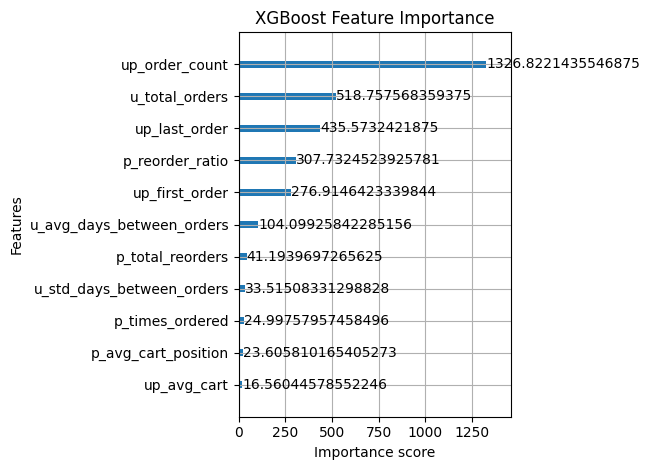

In [46]:
# Feature Importance
xgb.plot_importance(clf, max_num_features=20, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

In [47]:
# Class imbalance handling

# Use imbalance ratio
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

In [48]:
clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=7,
    learning_rate=0.1,
    n_estimators=100
)

In [52]:
# Train
clf.fit(X_train, y_train)

c:\Users\erand\anaconda3\envs\study\lib\site-packages\xgboost\training.py:183: UserWarning: [01:57:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [53]:
# Predict probs
y_proba = clf.predict_proba(X_val)[:, 1]

# Try threshold = 0.3
y_pred_thresh = (y_proba >= 0.3).astype(int)

print("Confusion Matrix (0.3 threshold):")
print(confusion_matrix(y_val, y_pred_thresh))
print(classification_report(y_val, y_pred_thresh))

Confusion Matrix (0.3 threshold):
[[789219 739555]
 [ 16275 149884]]
              precision    recall  f1-score   support

         0.0       0.98      0.52      0.68   1528774
         1.0       0.17      0.90      0.28    166159

    accuracy                           0.55   1694933
   macro avg       0.57      0.71      0.48   1694933
weighted avg       0.90      0.55      0.64   1694933



In [56]:
# # hyperparameter tuning
# xgb_model = xgb.XGBClassifier(
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=42,
#     tree_method='hist'  # fast training
# )

# param_dist = {
#     'max_depth': [4, 6, 8, 10],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'scale_pos_weight': [5, 7, 9, 11]  # imbalance control
# }

# rsearch = RandomizedSearchCV(
#     estimator=xgb_model,
#     param_distributions=param_dist,
#     n_iter=25,
#     scoring='f1',  # or 'recall' if that’s the main goal
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )

# rsearch.fit(X_train, y_train)

# print("Best Params:", rsearch.best_params_)

In [ ]:
# # Use the Best Parameters
# best_params = rsearch.best_params_

# # Rebuild model with best params
# best_xgb = xgb.XGBClassifier(
#     objective='binary:logistic',
#     use_label_encoder=False,
#     eval_metric='logloss',
#     tree_method='hist',
#     random_state=42,
#     **best_params
# )

# best_xgb.fit(X_train, y_train)

In [ ]:
# # Re-evaluate the Tuned Model
# y_proba = best_xgb.predict_proba(X_val)[:, 1]
# y_pred = (y_proba >= 0.3).astype(int)

# print("Confusion Matrix:")
# print(confusion_matrix(y_val, y_pred))
# print(classification_report(y_val, y_pred))
# print("ROC AUC:", roc_auc_score(y_val, y_proba))

In [ ]:
# # Predict Test Set
# test_proba = best_xgb.predict_proba(X_test_final)[:, 1]
# test_preds = (test_proba >= 0.3).astype(int)

In [ ]:
# test_df['predicted_reorder'] = test_preds

# # Get top products per user (optional)
# recommended = test_df[test_df['predicted_reorder'] == 1]

In [57]:
# Get Top-N Recommendations
val = X_val.copy()
val['user_id'] = train.loc[X_val.index, 'user_id'].values
val['product_id'] = train.loc[X_val.index, 'product_id'].values
val['reorder_proba'] = y_proba


In [58]:
# Top 10 products by predicted reorder probability per user
top_n = (
    val.groupby('user_id')
    .apply(lambda x: x.sort_values('reorder_proba', ascending=False).head(10))
    .reset_index(drop=True)
)

C:\Users\erand\AppData\Local\Temp\ipykernel_11292\3352008611.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values('reorder_proba', ascending=False).head(10))


In [59]:
top_n = top_n[['user_id', 'product_id', 'reorder_proba']]
top_n.head()

,user_id,product_id,reorder_proba
0,1,196,0.966596
1,1,12427,0.959425
2,1,38928,0.703314
3,1,41787,0.304066
4,1,10326,0.293103


In [62]:
# Save model + files
# Save model
joblib.dump(clf, '../models/xgb_reorder_model.pkl')

# Optional: save top_n as a CSV to use in app
top_n.to_csv('../prediction/user_product_predictions.csv', index=False)